<h1 style="text-align:center"> Exploring and Predicting Characteristics of Japanese Newspaper Headlines </h1> 
 <h2 style="text-align:center"> <i>STA208 Final Project (Spring 2017)</i> </h2> 
 <h3 style="text-align:center"> <i>Tzu-ping Liu and Gento Kato</i> </h3> 


[<h5 style="text-align:center"> Back to Summary Notebook </h5>](STA208_Project_Summary.ipynb)

<h1 style="text-align:center"> Section V </h1>
<h1 style="text-align:center"> <i>Predicting Negative Sentiments in Newspaper Headlines</i> </h1>

In [27]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In this section, we use supervised learning methods to predict the appearnce of negative sentiment in newspaper headlines. Using the word appearnce matrix data, we learn manually-coded negative sentiment (dichotomous category of 1 = negative and 0 = positive/neutral). Only 1000 cases in the full dataset have manual codes (See [Section II](STA208_Data_Description.ipynb) for data details). Therefore, we use randomly selected 80% of coded cases (or 800 cases) as trainig set to tune parameter values for each method [Subsection 2], and assess their performance on remaining 20% of coded cases (or 200 cases) [Subsection 3]. In the last subsection, we use several well-performed methods to machine-code negative sentiment in the full original dataset. The given codes are used in following sections to conduct further assessment on data.

## 1. Prepare Data

### 1.1 Import Required Modules

To start with, we import python modules that are necessary for the analysis. We use <code>numpy</code>, <code>pandas</code> for the data manipulation, <code>sklearn</code> for various classification methods, and <code>matplotlib</code> for result visualization. In addition, we import user-defined functions from <code>gentokfunc.py</code> file in <code>codes</code> directory.

In [297]:
#%reset

# Computation Timer
from timeit import default_timer as trec

## Data Mining
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Classification Method
from sklearn import preprocessing, neighbors ## KNN
import sklearn.linear_model as skl_lm ## Linear Methods (Logit)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis ## Linear Discricimant Analysis
from sklearn.svm import SVC ## Support Vector Machine 
#from sklearn.naive_bayes import BernoulliNB ## Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier ## Meta-Methods

## Model Selection and Metrics
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.metrics import auc, roc_auc_score, average_precision_score

## User Defined Classification Functions
#import sys; sys.path.insert(0, '../codes/') ## If codes path not on sys.path
import gentokfunc as gk; gk = reload(gk) # This is the file for user defined functions
from gentokfunc import MidpointNormalize # class for plotting validation result

### 1.2 Load Data

The original data in use are <code>alldata_traincode_170510.csv</code> (for negative sentiment coding) and <code>allWrdMat10.csv.gz</code> (for word frequency matrix). Both data are stored in <code>data</code> folder located in the highest level of this project (not <code>data_public</code> folder). Check [Section II](STA208_Data_Description.ipynb) for more data details. 

### 1.3 Create Training Set and Test Set

From the original data, we first extract 1000 rows that have values for manually-coded negative sentiment (1 = negative, 0 = positive/neutral). Then, to conduct and assess classification methods in following subsections, we split the coded data into training set and test set, with test set being 30% of the coded data. The below table describes the manual-coding distribution in training set and test set. In each dataset, roughly 30% of headlines are coded as negative (=1) and remaining 70% are coded as positive or neutral (=0).

In [260]:
## Import Data
alldata = pd.read_csv("../../data/alldata_traincode_170510.csv", encoding='CP932')
allWrdMat10 = pd.read_csv("../../data/allWrdMat10.csv.gz", encoding='CP932')
## Set X and y for Classification
targetx = allWrdMat10
targety = alldata

## Test on Politics Data (FOR THIS EXAMPLE)
#politicsdata = pd.read_csv('../data_public/politicsdata_traincode.csv', encoding='CP932', na_values='NA')
#politicsWrdMat10 = pd.read_csv('../data_public/politicsWrdMat10.csv', encoding='CP932', na_values='NA')
#targetx = politicsWrdMat10
#targety = politicsdata

In [272]:
# Create Design Matrix
X = np.array(targetx.loc[targety['train'] == 1,:])
y = np.array(targety.loc[targety['train'] == 1,'codeN'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=237843)

In [434]:
pd.DataFrame({'train':np.array(pd.Series(y_train).value_counts()),
             'test':np.array(pd.Series(y_test).value_counts())}, 
             index = ["0: Positive/Neutral", "1: Negative"], 
             columns = ['train','test']).transpose()

,0: Positive/Neutral,1: Negative
train,563,237
test,137,63


## 2. Tune Parameter Values for Classification Methods

Using the training set generated in the previous subsection, we fit various classification methods to the given dataset. Those methods include K nearest means (KNN), logistic regression with ridge penalty, linear discriminant analysis (LDA), support vector machine with RBF kernel (SVM-RBF), decision tree, bagging with decision tree, random forest, and boosting (Adaboost) with deicision tree. 

&nbsp;&nbsp;&nbsp;&nbsp; In this subsection, we describe the process of tuning parameters for each classification method, based on accuracy score. In all cases, optimal parameter values are assessed with 5-fold cross validation using the training set.  The classification results on test set are compared and evaluated in the next subsection. 

### 2.1 K Nearest Neighbors (KNN)

In K nearest neighbors method, the parameter of interest is $k$, the number of neightbors to consider in the estimation. We consider the total of 25 parameter values $k \in  \{1,3,5,...,45,47,49\}$. The computation time for the optimization is shown as follows: 

In [280]:
## Classifier
knn = neighbors.KNeighborsClassifier() ##knn estimation

## Tune k 

start = trec()
#params = {'n_neighbors':[1,5,10,50,100,200,500]}
params = {'n_neighbors':np.arange(1,51,2).tolist()}
optparam_knn, optscore_knn, values_knn, scores_knn = gk.class_optparam(X_train, y_train, knn, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 184.838 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [281]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_knn:
    print i, optparam_knn[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_knn)

From 5-Fold Cross Validation, the best parameter values are: 

n_neighbors [11, 19]

The corresponding accuracy score is 0.70750


The accuracy scores for the considered set of paremeter values can be plotted as follows:

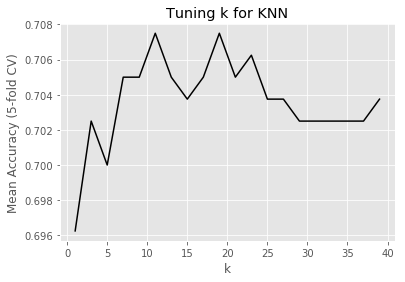

In [365]:
# Plotting Accuracy Score by k
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(values_knn, scores_knn, 'k-')
plt.title('Tuning k for KNN')
plt.xlabel('k')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()

From the above, the optimal parameter values for KNN are $k = \{11,19\}$. We then refit these two models on training set and use them to predict codes in test set. The outcomes will be used in the next subsection. Computation time for each estimation is presented below:

In [366]:
## On Test Set
start = trec()
knn1 = neighbors.KNeighborsClassifier(n_neighbors = 11) # Optimal k = 11
knn1fpr, knn1tpr, knn1rocauc, knn1prec, knn1rec, knn1prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, knn1)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 2.350 seconds


In [367]:
## On Test Set
start = trec()
knn2 = neighbors.KNeighborsClassifier(n_neighbors = 19) # Optimal k = 19
knn2fpr, knn2tpr, knn2rocauc, knn2prec, knn2rec, knn2prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, knn2)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 2.355 seconds


### 2.2 Logistic Regression (With Newton Conjugate Solver & Ridge Penalty)

In logistic regression, we can optimize the size of ridge penalty $\lambda$. In <code>scikit-learn</code> implementation of logistic regression, $C$ parameter is given as the inverse of $\lambda$ (larger $C$ indicates smaller penalty).  We consider the total of 10 parameter values $C \in  \{0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000\}$. The computation time for the optimization is shown as follows: 

In [289]:
## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
#params = {'C':np.arange(1,51,1).tolist()}
optparam_logit, optscore_logit,values_logit,scores_logit = gk.class_optparam(X_train, y_train, logit, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 58.868 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [290]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit:
    print i, optparam_logit[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit)

From 5-Fold Cross Validation, the best parameter values are: 

C [1000.0]

The corresponding accuracy score is 0.77125


The accuracy scores for the considered set of paremeter values can be plotted as follows:

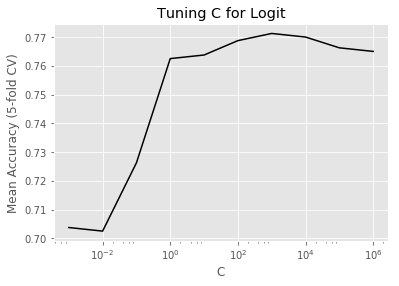

In [291]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit, scores_logit, 'k-')
#plt.plot(values_logit, scores_logit, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()

From the above, the optimal penalty size for logistic regression is $C = 1000$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [292]:
## On Test Set with C =　1000
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = 1000)
logitfpr, logittpr, logitrocauc, logitprec, logitrec, logitprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, logit)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 1.695 seconds


### 2.3 Linear Discriminant Analysis (LDA)

In linear discriminant analysis, <code>scikit-learn</code> implementation of linear discriminant analysis provide the parameter called $shrinkage$. According to its documentation, "a value of 0 corresponds to no shrinkage (which means the empirical covariance matrix will be used) and a value of 1 corresponds to complete shrinkage (which means that the diagonal matrix of variances will be used as an estimate for the covariance matrix)". Given this nature of the parameter, we consider the total of 11 parameter values $shrinkage \in  \{0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0\}$. The computation time for the optimization is shown as follows: 

In [328]:
## Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver="lsqr")

## Tune Shrinkage parameter
start = trec()
params = {'shrinkage':np.arange(0.0,1.1,0.1).tolist()}
optparam_lda, optscore_lda,values_lda,scores_lda = gk.class_optparam(X_train, y_train, lda, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 19755.958 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [329]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_lda:
    print i, optparam_lda[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_lda)

From 5-Fold Cross Validation, the best parameter values are: 

shrinkage [0.8]

The corresponding accuracy score is 0.77750


The accuracy scores for the considered set of paremeter values can be plotted as follows:

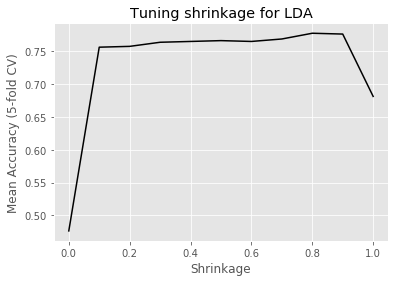

In [330]:
# Plotting Accuracy Score by shrinkage
plt.rcParams["figure.figsize"] = (6,4)
#plt.semilogx(values, scores, 'k-')
plt.plot(values_lda, scores_lda, 'k-')
plt.title('Tuning shrinkage for LDA')
plt.xlabel('Shrinkage')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()

From the above, the optimal parameter value in LDA is $shrinkage = 0.8$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [336]:
start = trec()
## On Test Set
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage = 0.8) 
ldafpr, ldatpr, ldarocauc, ldaprec, ldarec, ldaprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, lda)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 353.682 seconds


### 2.4 Support Vector Machine with RBF Kernel (SVM-RBF)

In [319]:
# Tune C and gamma for SVC with RBF Kernel
start = trec()
params = {'C': [0.01,0.1,1,10,100,1000,10000], 'gamma':[0.00001,0.0001,0.001,0.01, 0.1, 1,10]}
svmcl = SVC(kernel='rbf', probability=True)
optparam_svm, optscore_svm, values1_svm, values2_svm, scores_svm = gk.class_optparam(X_train, y_train, svmcl, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 4261.951 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [320]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_svm:
    print i, optparam_svm[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_svm)

From 5-Fold Cross Validation, the best parameter values are: 

C [100.0]
gamma [0.01]

The corresponding accuracy score is 0.76375


The accuracy scores for the considered set of paremeter values can be plotted as follows:

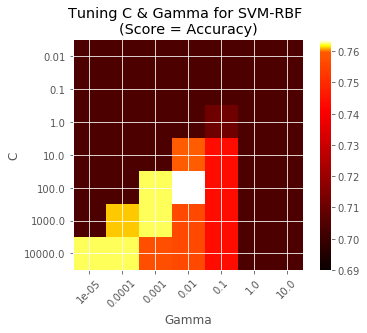

In [324]:
## Plot Validation Result
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_svm, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.69, midpoint=0.76))
plt.xlabel('Gamma'); plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(values2_svm)), values2_svm, rotation=45)
plt.yticks(np.arange(len(values1_svm)), values1_svm)
plt.title('Tuning C & Gamma for SVM-RBF \n(Score = Accuracy)')
plt.show()

From the above, the optimal parameter values in SVM-RBF are $C = 100$ and $gamma = 0.01$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [325]:
start = trec()
## On Test Set
svmcl = SVC(probability=True, C = 100, gamma = 0.01)
svmfpr, svmtpr, svmrocauc, svmprec, svmrec, svmprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, svmcl)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 30.708 seconds


### 2.5 Decision Tree

In [468]:
## Decision Tree 
dt = DecisionTreeClassifier(random_state = 13453, class_weight = "balanced")

## Tune Maximum Depth parameter
start = trec()
params = {'max_depth':[2,3,5,7,10,15,30,50]}
optparam_dt, optscore_dt,values_dt,scores_dt = gk.class_optparam(X_train, y_train, dt, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 16.338 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [487]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_dt:
    print i, optparam_dt[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_dt)

From 5-Fold Cross Validation, the best parameter values are: 

max_depth [3, 10]

The corresponding accuracy score is 0.74875


The accuracy scores for the considered set of paremeter values can be plotted as follows:

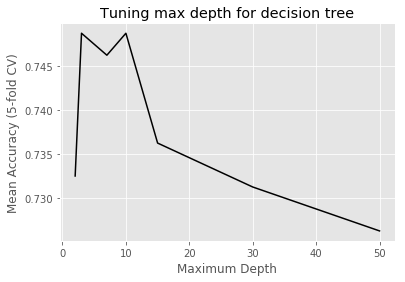

In [470]:
# Plotting Accuracy Score by shrinkage
plt.rcParams["figure.figsize"] = (6,4)
#plt.semilogx(values, scores, 'k-')
plt.plot(values_dt, scores_dt, 'k-')
plt.title('Tuning max depth for decision tree')
plt.xlabel('Maximum Depth')
plt.ylabel('Mean Accuracy (5-fold CV)')

plt.show()

From the above, the optimal maximum search depth for decision tree method are $3$ and $10$. We then refit these models on training set and use them to predict codes in test set. The outcomes will be used in the next subsection. Computation time for each estimation is presented below:

In [471]:
start = trec()
## Decision Tree 
dt1 = DecisionTreeClassifier(random_state = 13453, class_weight = "balanced", max_depth = 3)
## On Test Set
dt1fpr, dt1tpr, dt1rocauc, dt1prec, dt1rec, dt1prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, dt1)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 0.216 seconds


In [472]:
start = trec()
## Decision Tree 
dt2 = DecisionTreeClassifier(random_state = 13453, class_weight = "balanced", max_depth = 10)
## On Test Set
dt2fpr, dt2tpr, dt2rocauc, dt2prec, dt2rec, dt2prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, dt2)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 0.395 seconds


### 2.6 Bagging with Decision Tree

In [484]:
## Bagging
start = trec()
params = {'n_estimators': [5,10,20,50]} 
bag = BaggingClassifier(random_state = 23465, n_jobs = -1)
optparam_bag, optscore_bag, values_bag, scores_bag = gk.class_optparam(X_train, y_train, bag, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 118.035 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [485]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_bag:
    print i, optparam_bag[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_bag)

From 5-Fold Cross Validation, the best parameter values are: 

n_estimators [10]

The corresponding accuracy score is 0.75250


The accuracy scores for the considered set of paremeter values can be plotted as follows:

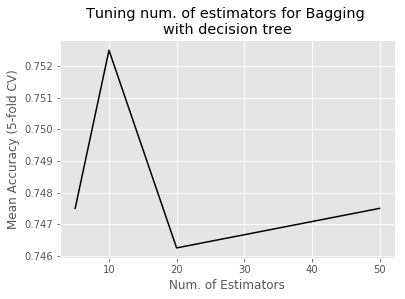

In [489]:
# Plotting Accuracy Score by n_estimators
plt.rcParams["figure.figsize"] = (6,4)
#plt.semilogx(values, scores, 'k-')
plt.plot(values_bag, scores_bag, 'k-')
plt.title('Tuning num. of estimators for Bagging \nwith decision tree')
plt.xlabel('Num. of Estimators')
plt.ylabel('Mean Accuracy (5-fold CV)')

plt.show()

From the above, the optimal number of estimators to average in bagging is $10$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [490]:
start = trec()
## Bagging
bag = BaggingClassifier(random_state = 23465, n_jobs = -1, n_estimators = 10)
## On Test Set
bagfpr, bagtpr, bagrocauc, bagprec, bagrec, bagprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, bag)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 4.422 seconds


### 2.7 Random Forest 

In [347]:
## Random Forest
## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [10,50,100,200,500],'max_features':["sqrt","log2", None]} 
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2)
optparam_rf, optscore_rf, values1_rf, values2_rf, scores_rf = gk.class_optparam(X_train, y_train, rf, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 1201.533 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [348]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_rf:
    print i, optparam_rf[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf)

From 5-Fold Cross Validation, the best parameter values are: 

n_estimators [100]
max_features ['sqrt']

The corresponding accuracy score is 0.75375


The accuracy scores for the considered set of paremeter values can be plotted as follows:

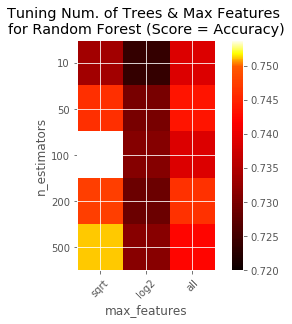

In [356]:
values2_rf = ['sqrt',"log2","all"]
## Plot Validation Result
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.72, midpoint=0.75))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf)), values2_rf, rotation=45)
plt.yticks(np.arange(len(values1_rf)), values1_rf)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()

From the above, for the random forest classifier, the optimal number of trees is $100$, and optimal maximum number of features is **square root** of number of features. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [435]:
## On Test Set
start = trec()
rf = RandomForestClassifier(n_estimators=100, max_features = "sqrt", random_state = 7899993, n_jobs=2)
rffpr, rftpr, rfrocauc, rfprec, rfrec, rfprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, rf)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 3.487 seconds


### 2.8 Boosting (Adaboost) with Decision Tree

In [495]:
## Adaboost
## Tune # of estimators and learning rate 
start = trec()
params = {'n_estimators': [10,50,100,200,500],'learning_rate':[0.2,0.4,0.6,0.8,1.]}
boost = AdaBoostClassifier(random_state = 7899993)
optparam_boost, optscore_boost, values1_boost, values2_boost, scores_boost = gk.class_optparam(X_train, y_train, boost, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 1812.685 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [496]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_boost:
    print i, optparam_boost[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf)

From 5-Fold Cross Validation, the best parameter values are: 

n_estimators [50, 200]
learning_rate [0.8, 0.6]

The corresponding accuracy score is 0.75375


The accuracy scores for the considered set of paremeter values can be plotted as follows:

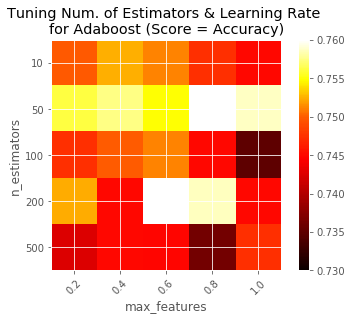

In [498]:
## Plot Validation Result
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_boost, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.73, midpoint=0.75))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_boost)), values2_boost, rotation=45)
plt.yticks(np.arange(len(values1_boost)), values1_boost)
plt.title('Tuning Num. of Estimators & Learning Rate \nfor Adaboost (Score = Accuracy)')
plt.show()

From the above, the optimal parameter values for Adaboost are {number of estimators $NE = 50$ & learning rate $LR = 0.8$} or {$NE=200$ & $LR=0.6$}. We then refit these models on training set and use them to predict codes in test set. The outcomes will be used in the next subsection. Computation time for the estimation is presented below:

In [499]:
start = trec()
## Adaboost
boost1 = AdaBoostClassifier(random_state = 7899993, n_estimators = 50, learning_rate = 0.8)
## On Test Set
boost1fpr, boost1tpr, boost1rocauc, boost1prec, boost1rec, boost1prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, boost1)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 4.572 seconds


In [500]:
start = trec()
## Adaboost
boost2 = AdaBoostClassifier(random_state = 7899993, n_estimators = 200, learning_rate = 0.6)
## On Test Set
boost2fpr, boost2tpr, boost2rocauc, boost2prec, boost2rec, boost2prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, boost2)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 18.344 seconds


## 3. Assess Classification Outcomes

### 3.1 ROC Curve

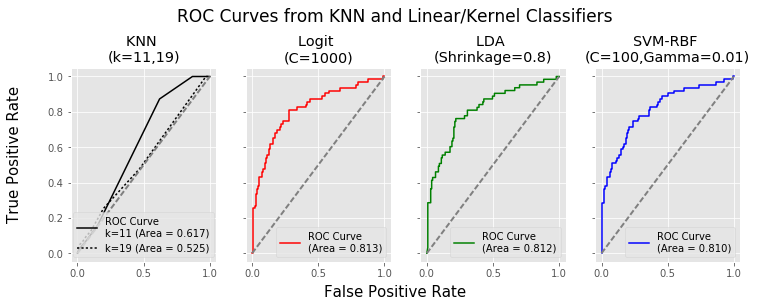

In [456]:
plt.rcParams["figure.figsize"] = (12,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.8)
f.text(0.5, 0.98, 'ROC Curves from KNN and Linear/Kernel Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(knn1fpr, knn1tpr, 'k-', label = 'ROC Curve \nk=11 (Area = %0.3f)' % knn1rocauc)
ax1.plot(knn2fpr, knn2tpr, 'k:', label = 'k=19 (Area = %0.3f)' % knn2rocauc)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('KNN \n(k=11,19)');
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower center")

ax2.plot(logitfpr, logittpr, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('Logit \n(C=1000)');
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(ldafpr, ldatpr, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % ldarocauc)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('LDA \n(Shrinkage=0.8)');
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(svmfpr, svmtpr, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % svmrocauc)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('SVM-RBF \n(C=100,Gamma=0.01)');
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")


plt.show()

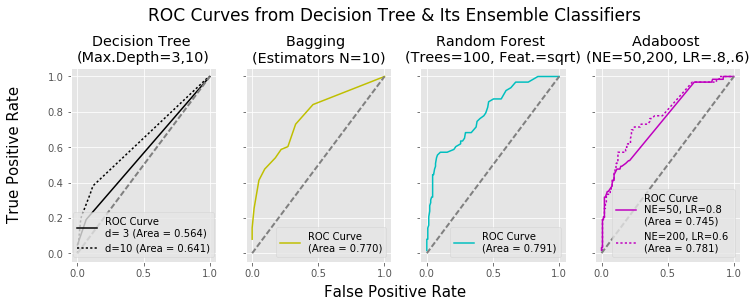

In [512]:
plt.rcParams["figure.figsize"] = (12,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.8)
f.text(0.5, 0.98, 'ROC Curves from Decision Tree & Its Ensemble Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(dt1fpr, dt1tpr, 'k-', label = 'ROC Curve \nd= 3 (Area = %0.3f)' % dt1rocauc)
ax1.plot(dt2fpr, dt2tpr, 'k:', label = 'd=10 (Area = %0.3f)' % dt2rocauc)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('Decision Tree \n(Max.Depth=3,10)');
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower center")

ax2.plot(bagfpr, bagtpr, 'y-', label = 'ROC Curve \n(Area = %0.3f)' % bagrocauc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('Bagging \n(Estimators N=10)');
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rffpr, rftpr, 'c-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('Random Forest \n(Trees=100, Feat.=sqrt)');
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(boost1fpr, boost1tpr, 'm-', label = 'ROC Curve \nNE=50, LR=0.8\n(Area = %0.3f)' % boost1rocauc)
ax4.plot(boost2fpr, boost2tpr, 'm:', label = 'NE=200, LR=0.6 \n(Area = %0.3f)' % boost2rocauc)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('Adaboost \n(NE=50,200, LR=.8,.6)');
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")


plt.show()

### 3.2 PR Curve

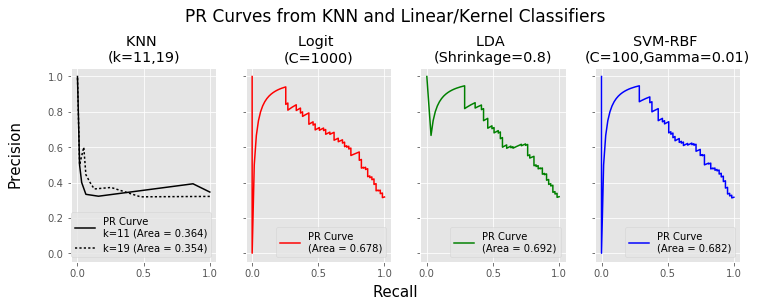

In [439]:
plt.rcParams["figure.figsize"] = (12,4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.8)
f.text(0.5, 0.98, 'PR Curves from KNN and Linear/Kernel Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(knn1rec, knn1prec, 'k-', label = 'PR Curve \nk=11 (Area = %0.3f)' % knn1prauc)
ax1.plot(knn2rec, knn2prec, 'k:', label = 'k=19 (Area = %0.3f)' % knn2prauc)
ax1.set_title('KNN \n(k=11,19)');
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitrec, logitprec, 'r-', label = 'PR Curve \n(Area = %0.3f)' % logitprauc)
ax2.set_title('Logit \n(C=1000)');
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(ldarec, ldaprec, 'g-', label = 'PR Curve \n(Area = %0.3f)' % ldaprauc)
ax3.set_title('LDA \n(Shrinkage=0.8)');
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(svmrec, svmprec, 'b-', label = 'PR Curve \n(Area = %0.3f)' % svmprauc)
ax4.set_title('SVM-RBF \n(C=100,Gamma=0.01)');
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()

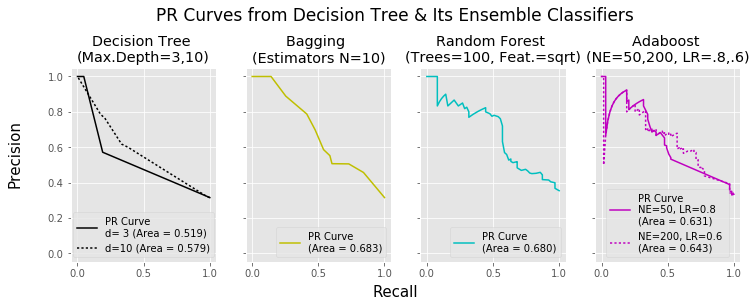

In [513]:
plt.rcParams["figure.figsize"] = (12,4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.8)
f.text(0.5, 0.98, 'PR Curves from Decision Tree & Its Ensemble Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(dt1rec, dt1prec, 'k-', label = 'PR Curve \nd= 3 (Area = %0.3f)' % dt1prauc)
ax1.plot(dt2rec, dt2prec, 'k:', label = 'd=10 (Area = %0.3f)' % dt2prauc)
ax1.set_title('Decision Tree \n(Max.Depth=3,10)');
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower center")

ax2.plot(bagrec, bagprec, 'y-', label = 'PR Curve \n(Area = %0.3f)' % bagprauc)
ax2.set_title('Bagging \n(Estimators N=10)');
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rfrec, rfprec, 'c-', label = 'PR Curve \n(Area = %0.3f)' % rfprauc)
ax3.set_title('Random Forest \n(Trees=100, Feat.=sqrt)');
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(boost1rec, boost1prec, 'm-', label = 'PR Curve \nNE=50, LR=0.8 \n(Area = %0.3f)' % boost1prauc)
ax4.plot(boost2rec, boost2prec, 'm:', label = 'NE=200, LR=0.6 \n(Area = %0.3f)' % boost2prauc)
ax4.set_title('Adaboost \n(NE=50,200, LR=.8,.6)');
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower center")

plt.show()

## 4. Predict Negative Sentiments in Full Dataset

### 4.1 

In [4]:
def class_simpred(Xall, X, y, clmod, n, testsize = .2):
    """
    Simulate and store predicted probabilities from classification methods.
    
    Input: All design matrix, Xall, training design matrix, X, response vector, y, 
           a classification model, clmod, itereation number, n
    Output: predicted probabilities, probyA
    """
    probyA = np.array([]).reshape(0,X.shape[1])
    for i in range(1, n+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=i) ## Train-Test Split
        clmod.fit(X_train,y_train) ## Fit Model on Training Data
        probyA_temp = clmod.predict_proba(Xall)[:,1]  # predicted all Y (for All y)        
        probyA = np.vstack([probyA, probyA_temp])
    return probyA